#### machine learning preliminary experiment

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import precision_score, accuracy_score,recall_score, f1_score
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

In [3]:
# load data
merged = pd.read_pickle('../dataset/merged_data_2class.pkl')
merged

,sex,age,edu,end,GAF,RIN,raw_reads,clean_reads,Q20,Q30,...,RBMY1A3P,AC126323.5,AC023824.3,AC087463.2,AL139135.2,KSR1P1,AC104454.1,AC098657.1,AC027309.3,AL732618.1
n337,1,14,8,0,56,8.1,7.911602,7.901730,97.24,92.79,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
n342,0,17,9,0,52,9.0,7.886186,7.877051,97.52,93.32,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
n346,0,17,9,0,47,8.8,7.936888,7.928224,97.39,93.09,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
n348,0,21,14,0,48,8.3,7.857012,7.849438,97.24,92.78,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
n349,0,18,9,1,46,8.3,7.973639,7.963862,98.07,94.73,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
n442c,1,14,8,0,66,8.8,7.989200,7.983345,97.68,93.76,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
n449c,0,15,9,0,72,7.9,7.994069,7.985102,97.71,93.89,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
n457c,1,27,16,0,71,6.9,7.999861,7.991270,97.48,93.40,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
n465c,1,14,8,0,60,7.5,8.022328,8.013831,97.73,93.97,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
from sklearn.utils import shuffle
shuffled = shuffle(merged)
labels = np.array(shuffled['end'])
features = np.array(shuffled.drop(columns=['end']))
print(labels.shape)
print(features.shape)

X = features
Y = labels

(112,)
(112, 59110)


#### XGBoost

In [8]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

other_params = {'eta': 0.3, 'n_estimators': 500, 'gamma': 0, 'max_depth': 6, 'min_child_weight': 1,
                'colsample_bytree': 1, 'colsample_bylevel': 1, 'subsample': 1, 'reg_lambda': 1, 'reg_alpha': 0,
                'seed': 33}

#cv_params = {'n_estimators': np.linspace(100, 1000, 10, dtype=int)} # 100
cv_params = {'n_estimators': np.linspace(1, 50, 11, dtype=int)} # 170
# cv_params = {'max_depth': np.linspace(1, 10, 10, dtype=int)} # 6

xgb_model = xgb.XGBClassifier(**other_params)
gs = GridSearchCV(xgb_model, cv_params, verbose=2, refit=True, cv=5, n_jobs=-1)
gs.fit(X,Y)
gs.best_params_

Fitting 5 folds for each of 11 candidates, totalling 55 fits


{'n_estimators': 15}

(mean) ACC:  0.8565217391304347 Precision:  0.0 Recall:  0.0 F1:  0.0 AUC:  0.889738942961146
(std) ACC:  0.06660518862807704 Precision:  0.0 Recall:  0.0 F1:  0.0 AUC:  0.0647831040255707


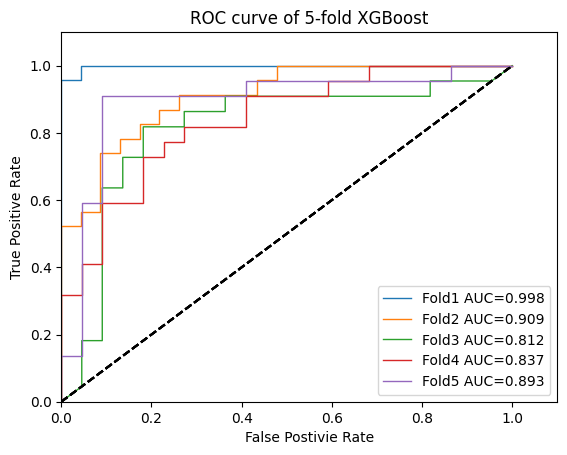

In [9]:
# 5-fold
model_name = 'XGBoost'
cv_result = []
cv_label = []
cv = KFold(n_splits=5)
for train_index, valid_index in cv.split(X):
    train_x,test_x = X[train_index], X[valid_index]
    train_y,test_y = Y[train_index], Y[valid_index]
    clf = xgb.XGBClassifier(n_jobs=-1,n_estimators=15,max_depth=6)
    clf.fit(train_x, train_y)
    result = clf.predict_proba(test_x)
    cv_result.append(result)
    cv_label.append(test_y)
#print(cv_result)
#print(cv_label)

acc_list = []
precision_list = []
recall_list = []
f1_list = []
auc_list = []

for i in range(5): # 5-fold evaluation
    y_score = cv_result[i].argmax(axis=1)                                   
    y_score_pro = cv_result[i] # (.., 2)
    y_one_hot = to_categorical(cv_label[i])
    y_score_one_hot = to_categorical(y_score)

    acc_list.append(accuracy_score(cv_label[i], y_score))
    precision_list.append(precision_score(cv_label[i], y_score))
    recall_list.append(recall_score(cv_label[i], y_score))
    f1_list.append(f1_score(cv_label[i], y_score))

    fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
    auc_list.append(auc(fpr, tpr))

    plt.plot(fpr, tpr, linewidth = 1,label='Fold' + str(i+1) + ' AUC=%.3f' % auc(fpr, tpr))
    plt.plot([0,1],[0,1], 'k--')

print('(mean) ACC: ', np.mean(acc_list), 'Precision: ', np.mean(precision_list), 'Recall: ', np.mean(recall_list), 'F1: ', np.mean(f1_list), 'AUC: ', np.mean(auc_list))
print('(std) ACC: ', np.std(acc_list), 'Precision: ', np.std(precision_list), 'Recall: ', np.std(recall_list), 'F1: ', np.std(f1_list), 'AUC: ', np.std(auc_list))
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC curve of 5-fold '  + model_name)
#plt.savefig('images2/roc-5fold-' + year + '-' + var + '.png',dpi=300)
plt.show()